#

# Peer-induced fairness framework for algorithmic bias auditing

###

* Example: sensitive attribute = firm's size, we treat micro-firms as protected group and non-micro firms as non-protected group
* Data: we collect data from UK Archive Small and Medium-Sized Enterprise Finance Monitor https://doi.org/10.5255/UKDA-SN-6888-26
* Peer identification threshold in this file is $0.3 \times Std_{IC}$, fitting model: xgboost, prediction model: logistic

#

## (1) Data Preprocessing

In [2]:
import sys
sys.path.append("../..")
from preprocessing import data_preprocess

import numpy as np
import pandas as pd


%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd

# Paths to the tab data files
data_paths = [
    '../../../datasets/SMEs_F/raw/sme_finance_monitor_q4_2012-q1_2015_data.tab',
    '../../../datasets/SMEs_F/raw/sme_finance_monitor_q3_2015_q4_2017.tab',
    '../../../datasets/SMEs_F/raw/sme_finance_monitor_q1_2018-q2_2020.tab'
]

# Combine the dataframes
df_list = [pd.read_csv(path, sep='\t') for path in data_paths]  # Assuming tab-separated values
df_count = pd.concat(df_list, ignore_index=True)

# Get the total number of entries
total_entries = df_count.shape[0]
print(f"The total number of entries in the combined dataset is: {total_entries}")

C:\Users\s2285280\AppData\Local\Temp\ipykernel_20564\4124027893.py:11: DtypeWarning: Columns (13,41,42,49,52,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,1907,1908,1911,1912,1913,1914,1933,1938,1939,1940,1941,1942,1943,1944,1945,1946,1963,2002,2003,2114,2115,2116,2117,2118,2119,2120,2121,2122,2123,2124,2125,2126,2127,2128,2129,2130,2131,2132,2133,2148,2149,2150,2151,2152,2153,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181,2182,2210,2215,2216,2217,2218,2219,2220,2225,2227) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(path, sep='\t') for path in data_paths]  # Assuming tab-separated values


The total number of entries in the combined dataset is: 141166


In [4]:
# Step1: Combine dataframe
# ..represents previous layer
df_combined = data_preprocess.combine_data(['../../../datasets/SMEs_F/raw/sme_finance_monitor_q4_2012-q1_2015_data.tab',
                                            '../../../datasets/SMEs_F/raw/sme_finance_monitor_q3_2015_q4_2017.tab',
                                            '../../../datasets/SMEs_F/raw/sme_finance_monitor_q1_2018-q2_2020.tab'],
                                            ['../../../datasets/SMEs_F/selection/selectedfeatures1.csv',
                                             '../../../datasets/SMEs_F/selection/selectedfeatures2.csv',
                                             '../../../datasets/SMEs_F/selection/selectedfeatures3.csv'],
                                             '../../../datasets/SMEs_F/selection/common_featuresname.csv')

In [5]:
# Step 2: Replace DK/Refused data
df_replace_dk_refused = data_preprocess.replace_dk_refused(df_combined)
# Step 3: Replace missing values in the combined data
replacena_df = data_preprocess.replace_missing_values(df_replace_dk_refused)
# Step 4: Check column-wise missing ratio and select columns with ratio <= 0.5
del_hmc_df, NAN_ratios, keep_columns = data_preprocess.check_col_missing_ratio(replacena_df, 0.5)
# Step 5: Check row-wise missing ratio and select rows with ratio < 0.2
del_hmr_df = data_preprocess.check_row_missing_ratio(del_hmc_df, 0.2)
# Step 6: Impute missing data in the selected columns
fill_df = data_preprocess.impute_missing_data(del_hmr_df)
# Step 7: Convert data to integer type
int_df = data_preprocess.convert_to_int(fill_df)
# Step 8: Remove NAN Final Outcomes
delfona_df = data_preprocess.remove_nan_final_outcomes(int_df)
# Step 9: Merge final outcomes
part_mergefo_df, all_mergefo_df = data_preprocess.merge_final_outcomes(delfona_df, int_df)
# Step 10: Merge regular and sensitve attributes
merge_df, int_merge_df = data_preprocess.merge_attributes(part_mergefo_df, all_mergefo_df)
# Step 11: Export csv and xlsx
# data_preprocess.export_csv(merge_df, int_merge_df)
# data_preprocess.export_xlsx(merge_df, int_merge_df)

C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\preprocessing\data_preprocess.py:241: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  delfo5_df = delfo5_df[delfona_df['final outcomes'] != 5.0]
C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\preprocessing\data_preprocess.py:242: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  delfo5_df = delfo5_df[delfona_df['final outcomes'] != '5']


#

## (2) Prediction

In [6]:
columns_to_drop = ['gender', 'age','race','new gender','new race','new age', 'establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']

merge_df = merge_df.drop(columns=columns_to_drop)

In [7]:
nominals = ['principal', 'legal status']
ordinals = [col for col in merge_df.columns if col not in nominals]

In [8]:
from preprocessing.encoding import FeatureEncoder

drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

X_part = merge_df.drop(drop_list, axis=1)
X_part_nominals = [x for x in X_part if x in nominals]


part_encoder = FeatureEncoder(X_part)
X_part_encoded_df = part_encoder.one_hot_encode(columns=X_part_nominals)

In [9]:
from model import xgboost
from model.xgboost import XGBoostModel

# train model for membership 
model = XGBoostModel(X_part_encoded_df, merge_df['new size'])
model.train_model()
model.evaluate_performance()
model.generate_test_report()
model.calculate_auc()
model.calculate_acc()
model.calculate_f1()
model.calculate_recall()
model.calculate_precision()



# prediction
X_part = X_part_encoded_df
yb_pred_all = model.predict_proba(X_part)
yb_prediction_all = model.predict(X_part)

# add prediction results
merge1_df = merge_df.copy()
merge1_df['Pr(S=0)'] = yb_pred_all[:, 0]
merge1_df['PS Prediction'] = yb_prediction_all

5-fold Cross Validation AUC: [0.86311595 0.82173918 0.84493841 0.84027712 0.83850607]
Mean AUC: 0.8417153437882423
Standard Deviation of the Mean AUC: 0.013264907450145585
Standard Error of the Mean AUC: 0.0066324537250727926
5-fold Cross Validation Accuracy: [0.80168269 0.76081731 0.78245192 0.76322115 0.77135981]
Mean Accuracy: 0.7759065768767935
Standard Deviation of the Mean Accuracy: 0.014943418602823895
Standard Error of the Mean Accuracy: 0.0074717093014119475
5-fold Cross Validation Precision: [0.80529301 0.77629063 0.78373383 0.76599634 0.76048951]
Mean Precision: 0.7783606634152582
Standard Deviation of the Mean Precision: 0.015689241419548836
Standard Error of the Mean Precision: 0.007844620709774416
5-fold Cross Validation Recall: [0.87295082 0.83196721 0.86885246 0.85860656 0.89139344]
Mean Recall: 0.8647540983606558
Standard Deviation of the Mean Recall: 0.019526441392740332
Standard Error of the Mean Recall: 0.009763220696370166
5-fold Cross Validation F1: [0.83775811 0.

In [10]:
from model import logistic
from model.logistic import LogisticRegressionModel

# train model for favourable outcomes likelihood
model = LogisticRegressionModel(X_part_encoded_df, merge_df['Binary Y'])
model.train_model()
model.evaluate_performance()
model.generate_test_report()
model.calculate_auc()
model.calculate_acc()
model.calculate_f1()
model.calculate_recall()
model.calculate_precision()

# prediction
X_part = X_part_encoded_df
yb_pred_all = model.predict_proba(X_part)
yb_prediction_all = model.predict(X_part)

# add prediction results
merge_pred_ps_df = merge1_df.copy()
merge_pred_ps_df['Pr(Y=1)'] = yb_pred_all[:, 1]
merge_pred_ps_df['Binary Prediction'] = yb_prediction_all

5-fold Cross Validation AUC: [0.73073628 0.68692296 0.80880071 0.82740968 0.82877841]
Mean AUC: 0.7765296102212549
Standard Deviation of the Mean AUC: 0.05742216380805111
Standard Error of the Mean AUC: 0.028711081904025555
5-fold Cross Validation Accuracy: [0.81490385 0.79447115 0.85216346 0.84735577 0.84837545]
Mean Accuracy: 0.8314539364065536
Standard Deviation of the Mean Accuracy: 0.0228461028479526
Standard Error of the Mean Accuracy: 0.011423051423976299
5-fold Cross Validation Precision: [0.82129743 0.81727159 0.8665786  0.85919166 0.86315789]
Mean Precision: 0.8454994338763775
Standard Deviation of the Mean Precision: 0.021569319059361346
Standard Error of the Mean Precision: 0.010784659529680673
5-fold Cross Validation Recall: [0.98821797 0.96312684 0.96755162 0.9719764  0.96755162]
Mean Recall: 0.9716848914549855
Standard Deviation of the Mean Recall: 0.008727377528964873
Standard Error of the Mean Recall: 0.004363688764482437
5-fold Cross Validation F1: [0.89705882 0.88422

In [11]:
from analysis import description
from analysis.description import DataFrameAnalyzer

analyzer = DataFrameAnalyzer(merge_pred_ps_df, 'Binary Y', 'new size', 'Binary Prediction')
analyzer.analyze_dataframe()


new size value counts:
1    2440
0    1719
Name: new size, dtype: int64
Binary Y value counts:
1    3391
0     768
Name: Binary Y, dtype: int64

Binary Prediction value counts:
1    3873
0     286
Name: Binary Prediction, dtype: int64

Subset Analysis for new size '1':
Binary Y value counts:
1    2159
0     281
Name: Binary Y, dtype: int64

Binary Prediction value counts:
1    2371
0      69
Name: Binary Prediction, dtype: int64

Subset Analysis for new size '0':
Binary Y value counts:
1    1232
0     487
Name: Binary Y, dtype: int64

Binary Prediction value counts:
1    1502
0     217
Name: Binary Prediction, dtype: int64


#

# (3) Statistics

In [12]:
# data preparation
from analysis import greater_than_caplier_calculator
from analysis import data_divide_calculator

protect_df, nonprotect_df, accepted_df, rejected_df, pred_accepted_df, pred_rejected_df, protect_ps, nonprotect_ps = data_divide_calculator.data_divide(merge_pred_ps_df, 'new size','Binary Y', 'Binary Prediction', 'Pr(S=0)')

In [13]:
from analysis import statistics
from analysis.statistics import DataFrameStatistics

stats_calculator = DataFrameStatistics(merge_df)
merge_df_table = stats_calculator.calculate_statistics()


stats_calculator = DataFrameStatistics(protect_df)
protect_df_table = stats_calculator.calculate_statistics()


stats_calculator = DataFrameStatistics(nonprotect_df)
nonprotect_df_table = stats_calculator.calculate_statistics()

In [14]:
proportions = stats_calculator.calculate_proportions()
proportions

,Column,Value,Proportion (%)
0,risk,1,19.59
1,risk,2,43.11
2,risk,3,25.98
3,risk,4,11.31
4,principal,1,6.64
...,...,...,...
4184,Pr(Y=1),0,0.04
4185,Pr(Y=1),0,0.04
4186,Pr(Y=1),0,0.04
4187,Binary Prediction,0,2.83


#

# (4) Matching

In [16]:
from matching import caplier_matching
from matching.caplier_matching import CaplierMatching

matcher = CaplierMatching(merge_pred_ps_df, 'new size', K=15, caplier_ratio=0.3)
matched_df = matcher.caplier_matching()
a, b, weighted_protect_ps, weighted_nonprotect_ps = matcher.calculate_weighted_ps()

In [17]:
from analysis import bootstrapping
from analysis.bootstrapping import BootstrapSampler

sampler = BootstrapSampler(nonprotect_df, protect_df, matched_df,sampling_times=100, draws_per_sample=30, determine=35)
bootstrapped_samples = sampler.sample()
pr_y_means = sampler.calculate_means(bootstrapped_samples)

single_less_sided_results = sampler.perform_test(pr_y_means, direction='less')
single_greater_sided_results = sampler.perform_test(pr_y_means, direction='greater')
double_sided_results = sampler.perform_test(pr_y_means, direction='two-sided')

#

# (5) Visualisation

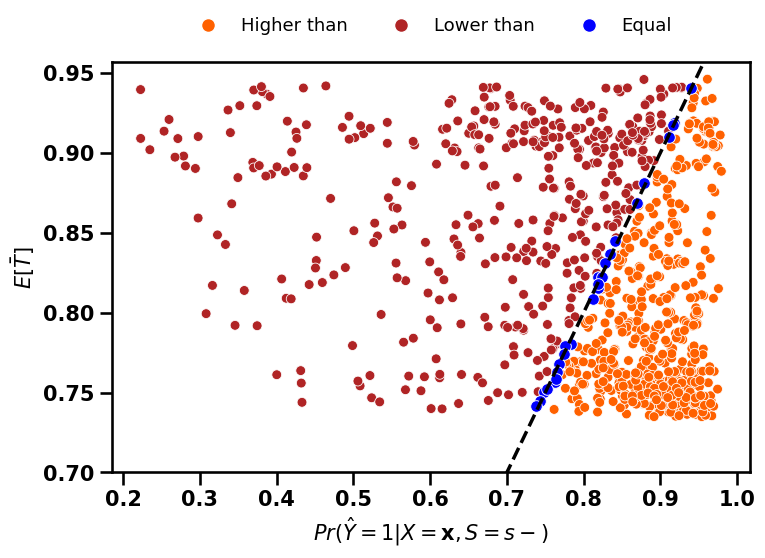

In [18]:
plot_df = sampler.plot_treatment_comparison(pr_y_means,double_sided_results)

# (6) Treatment categories

## 6.1 Extreme discrimination

Number of colored points: 271


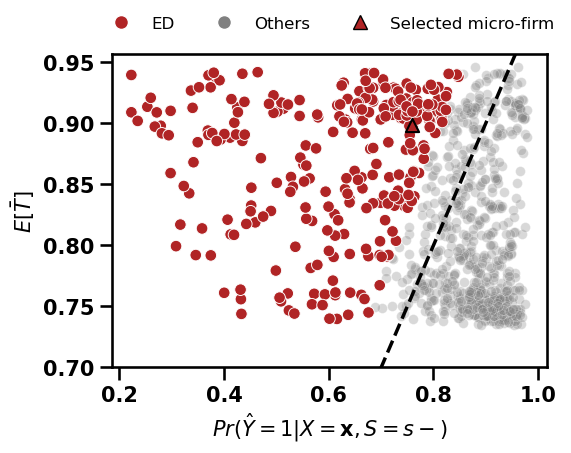

the data ratio is: 0.2788065843621399
#B02425 Protected Pr(Y=1) Mean: 0.6108813021650539, Standard Deviation: 0.15445696319634572
#B02425 Matched Mean Pr(Y=1) Mean: 0.8709013094259033, Standard Deviation: 0.05549262836028852


C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\analysis\extreme_analysis.py:193: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data1, shade=False, color=color, linewidth=7, label='Micro-firms', linestyle='--')
C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\analysis\extreme_analysis.py:194: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=False, color=density_color, linewidth=7, label='Peers group')


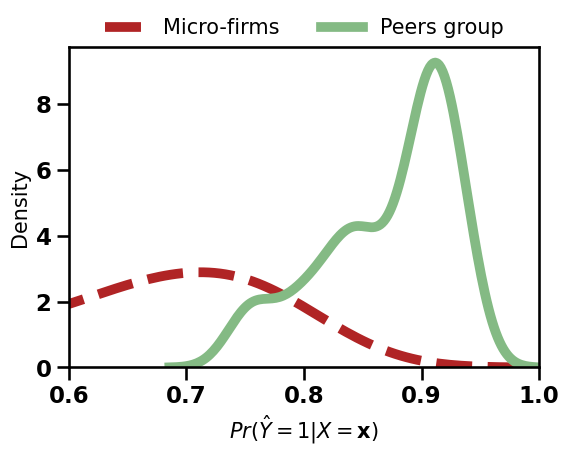

Kurtosis: -0.23020247166229968
Standard Deviation: 0.013288818195138311
Density Mean: 0.8981377755204231
Line Value (A): 0.7598617718188504


C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\analysis\extreme_analysis.py:637: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade=False, bw_adjust=bw_adjust, color=density_color, linewidth=7, label='Peers')


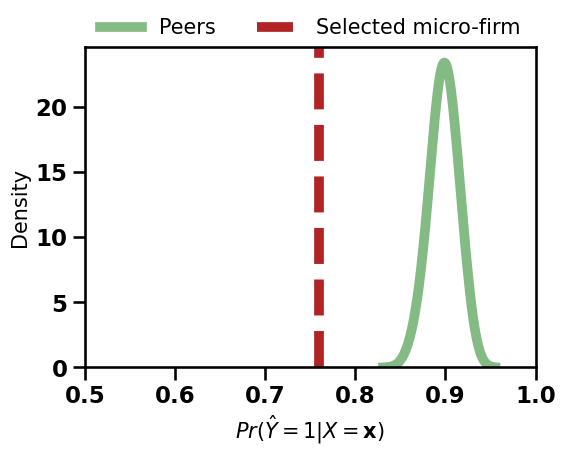

In [20]:
from analysis import extreme_analysis
from analysis.extreme_analysis import DensityScatterPlotter

treatment_threshold = 0.2 * protect_df['Pr(Y=1)'].std()

plotter = DensityScatterPlotter(protect_df, nonprotect_df, bootstrapped_samples, result_type='single_greater_sided_results', comparison_type='less than')

single_greater_less_than_plot_df, single_greater_less_than_gray_df, single_greater_less_than_color_df = plotter.plot_scatter(pr_y_means, 1, single_greater_sided_results, threshold_type='floating', floating_ratio=0.1, mean_diff_threshold=treatment_threshold, p_value_threshold=0.05)

plotter.plot_group_density(single_greater_less_than_color_df, 'protected Pr(Y=1)', 'matched mean Pr(Y=1)', '#B02425', density_color='#84BA84')
plotter.plot_case_density(protect_df,pr_y_means, 1, show_line=True, line_color='#B02425', density_color='#84BA84')

In [21]:
line_1,b = plotter.try_2(single_greater_less_than_color_df,pr_y_means,label='single_greater_less than')

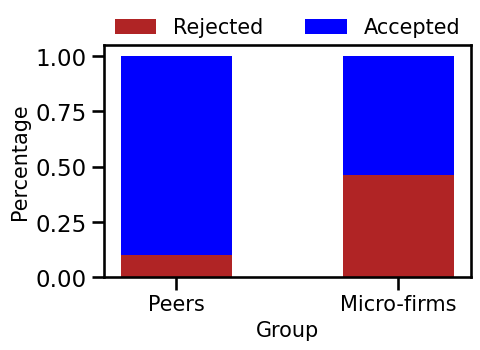

,Type,Binary Y,Count,Proportion
0,Nonprotect,0,81554,0.100312
1,Nonprotect,1,731446,0.899688
2,Protect,0,125,0.461255
3,Protect,1,146,0.538745


In [22]:
single_greater_less_than_group_results = plotter.group_ground_truth(single_greater_less_than_color_df,label='single_greater_less than')
single_greater_less_than_group_results

## 6.2 Slight discrimination

Number of colored points: 140


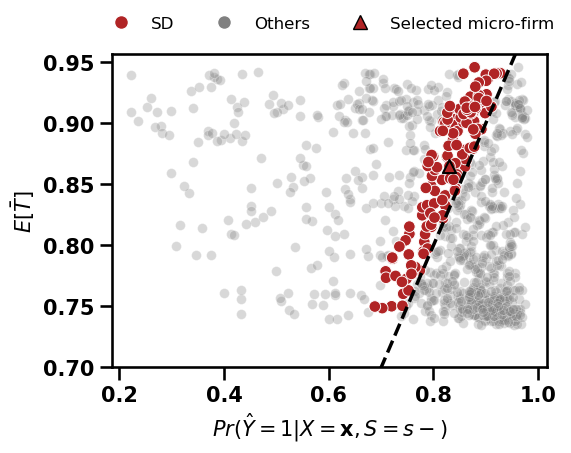

the data ratio is: 0.1440329218106996
#B02425 Protected Pr(Y=1) Mean: 0.8276176289058532, Standard Deviation: 0.053931397272861455
#B02425 Matched Mean Pr(Y=1) Mean: 0.8646812370713436, Standard Deviation: 0.053131727121416186


C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\analysis\extreme_analysis.py:193: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data1, shade=False, color=color, linewidth=7, label='Micro-firms', linestyle='--')
C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\analysis\extreme_analysis.py:194: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=False, color=density_color, linewidth=7, label='Peers group')


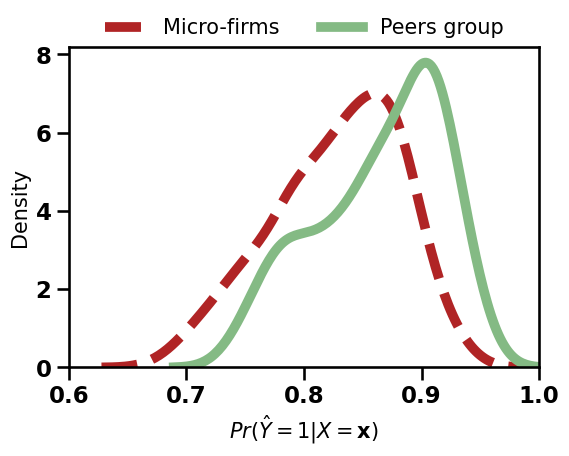

Kurtosis: 1.2773791238733283
Standard Deviation: 0.015042324554445267
Density Mean: 0.8648929714555371
Line Value (A): 0.8305155563766476


C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\analysis\extreme_analysis.py:637: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade=False, bw_adjust=bw_adjust, color=density_color, linewidth=7, label='Peers')


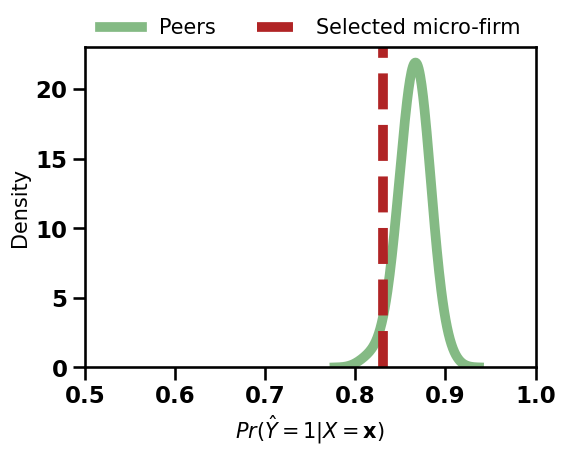

In [23]:
from analysis import extreme_analysis
from analysis.extreme_analysis import DensityScatterPlotter

plotter = DensityScatterPlotter(protect_df, nonprotect_df, bootstrapped_samples, result_type='single_greater_sided_results', comparison_type='between')
single_greater_between_plot_df, single_greater_between_gray_df, single_greater_between_color_df = plotter.plot_scatter(pr_y_means, 1708, single_greater_sided_results, threshold_type='floating', floating_ratio=0.1, mean_diff_threshold=treatment_threshold, p_value_threshold=0.05)

plotter.plot_group_density(single_greater_between_color_df, 'protected Pr(Y=1)', 'matched mean Pr(Y=1)', '#B02425', density_color='#84BA84')
plotter.plot_case_density(protect_df,pr_y_means, 1708, show_line=True, line_color='#B02425', density_color='#84BA84')

In [24]:
line_2,b = plotter.try_2(single_greater_between_color_df,pr_y_means,label='single_greater_between')

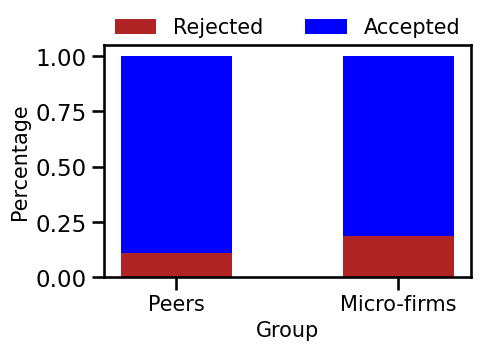

,Type,Binary Y,Count,Proportion
0,Nonprotect,0,45555,0.108464
1,Nonprotect,1,374445,0.891536
2,Protect,0,26,0.185714
3,Protect,1,114,0.814286


In [25]:
single_greater_between_group_results = plotter.group_ground_truth(single_greater_between_color_df,label='single_greater_between')
single_greater_between_group_results

## 6.3 Fairly treated

Number of colored points: 25


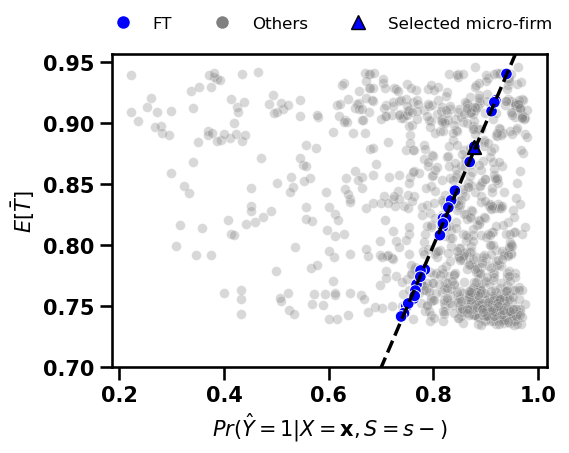

the data ratio is: 0.0257201646090535
blue Protected Pr(Y=1) Mean: 0.8160392688526653, Standard Deviation: 0.06037341402871622
blue Matched Mean Pr(Y=1) Mean: 0.8160571077850152, Standard Deviation: 0.0608438076175405


C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\analysis\extreme_analysis.py:193: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data1, shade=False, color=color, linewidth=7, label='Micro-firms', linestyle='--')
C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\analysis\extreme_analysis.py:194: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=False, color=density_color, linewidth=7, label='Peers group')


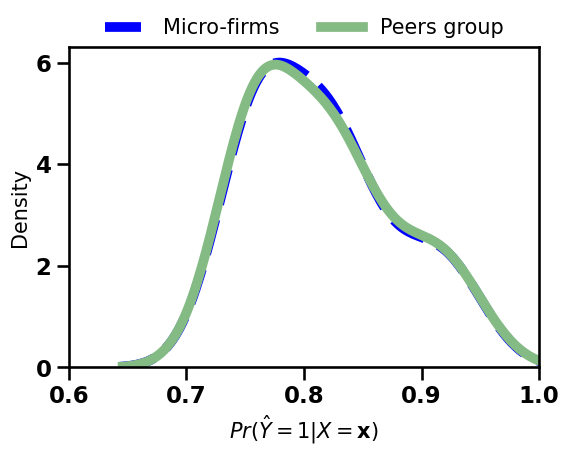

Kurtosis: -0.3758668628293713
Standard Deviation: 0.015016066466730581
Density Mean: 0.8807899803658431
Line Value (A): 0.8779813532815711


C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\analysis\extreme_analysis.py:637: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade=False, bw_adjust=bw_adjust, color=density_color, linewidth=7, label='Peers')


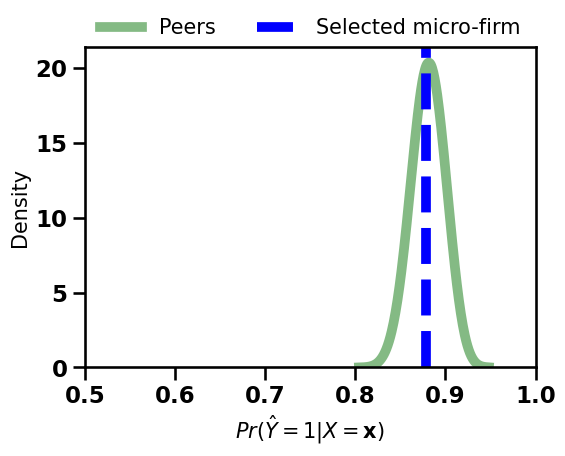

In [26]:
from analysis import extreme_analysis
from analysis.extreme_analysis import DensityScatterPlotter

plotter = DensityScatterPlotter(protect_df, nonprotect_df, bootstrapped_samples, result_type='double_sided_results', comparison_type='less than')
double_fair_plot_df, double_fair_gray_df, double_fair_color_df = plotter.plot_scatter(pr_y_means, 1624, double_sided_results, threshold_type='floating', floating_ratio=0.1, mean_diff_threshold=treatment_threshold, p_value_threshold=0.05)

plotter.plot_group_density(double_fair_color_df, 'protected Pr(Y=1)', 'matched mean Pr(Y=1)', 'blue', density_color='#84BA84')
plotter.plot_case_density(protect_df,pr_y_means, 1624, show_line=True, line_color='blue', density_color='#84BA84')

In [27]:
line_3,b = plotter.try_2(double_fair_color_df,pr_y_means,label='double')

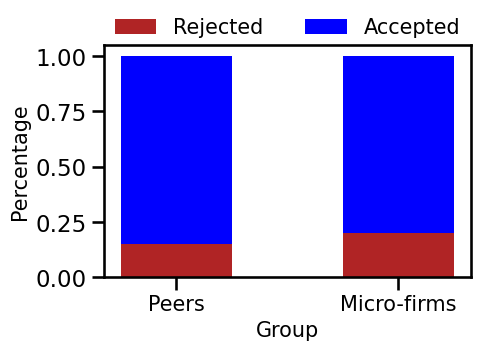

,Type,Binary Y,Count,Proportion
0,Nonprotect,0,11307,0.15076
1,Nonprotect,1,63693,0.84924
2,Protect,0,5,0.20000
3,Protect,1,20,0.80000


In [28]:
double_fair_group_results = plotter.group_ground_truth(double_fair_color_df,label='double')
double_fair_group_results

## 6.4 Slight priviledge

Number of colored points: 236


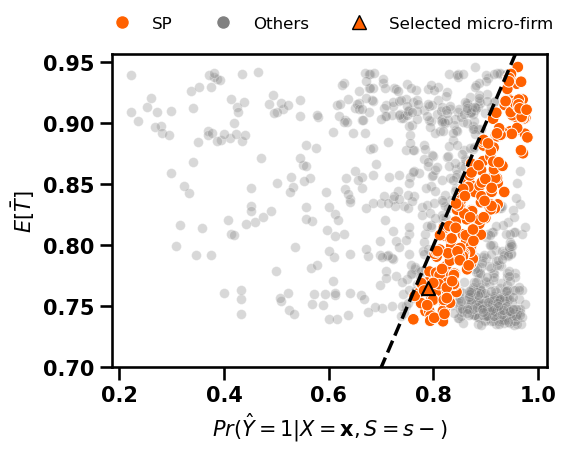

the data ratio is: 0.24279835390946503
#FF6100 Protected Pr(Y=1) Mean: 0.8752329717512333, Standard Deviation: 0.0577237247882513
#FF6100 Matched Mean Pr(Y=1) Mean: 0.8300126378626602, Standard Deviation: 0.056932769243384175


C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\analysis\extreme_analysis.py:193: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data1, shade=False, color=color, linewidth=7, label='Micro-firms', linestyle='--')
C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\analysis\extreme_analysis.py:194: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=False, color=density_color, linewidth=7, label='Peers group')


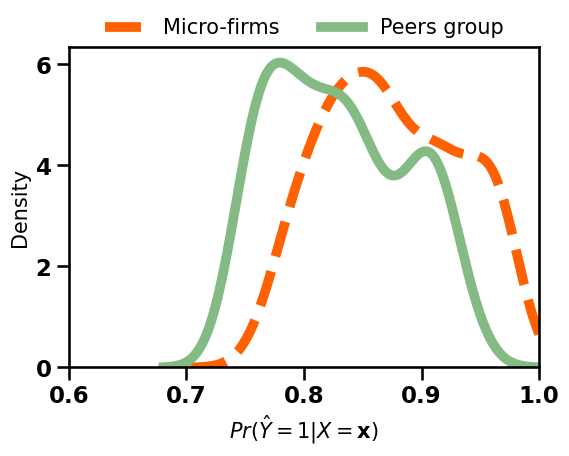

Kurtosis: 0.9164748231877624
Standard Deviation: 0.03192028537374964
Density Mean: 0.7650248690240143
Line Value (A): 0.7888285295466622


C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\analysis\extreme_analysis.py:637: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade=False, bw_adjust=bw_adjust, color=density_color, linewidth=7, label='Peers')


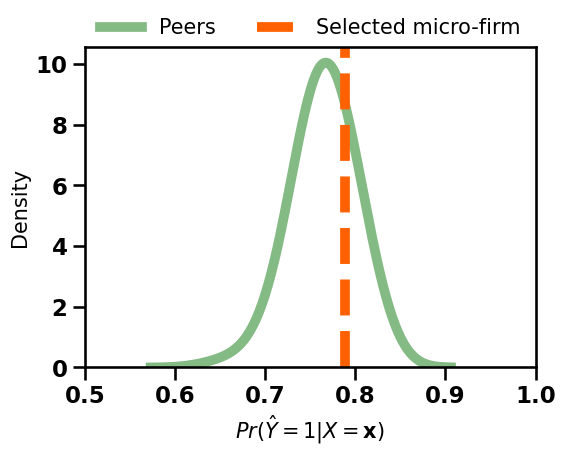

In [29]:
from analysis import extreme_analysis
from analysis.extreme_analysis import DensityScatterPlotter
plotter = DensityScatterPlotter(protect_df, nonprotect_df, bootstrapped_samples, result_type='single_less_sided_results', comparison_type='between')
single_less_between_plot_df, single_less_between_gray_df, single_less_between_color_df = plotter.plot_scatter(pr_y_means, 88, single_less_sided_results, threshold_type='floating', floating_ratio=0.1, mean_diff_threshold=treatment_threshold, p_value_threshold=0.05)

plotter.plot_group_density(single_less_between_color_df, 'protected Pr(Y=1)', 'matched mean Pr(Y=1)', '#FF6100', density_color='#84BA84')
plotter.plot_case_density(protect_df,pr_y_means, 88, show_line=True, line_color='#FF6100', density_color='#84BA84')

In [30]:
line_4,b = plotter.try_2(single_less_between_color_df,pr_y_means,label='single_less_between')

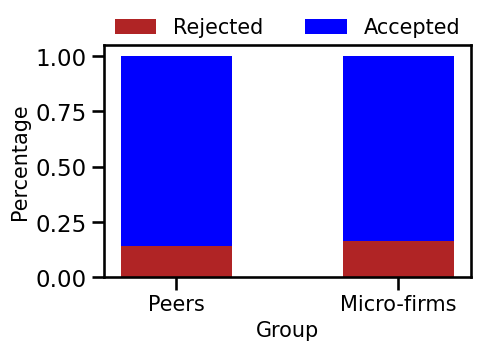

,Type,Binary Y,Count,Proportion
0,Nonprotect,0,100921,0.142544
1,Nonprotect,1,607079,0.857456
2,Protect,0,39,0.165254
3,Protect,1,197,0.834746


In [31]:
single_less_between_group_results = plotter.group_ground_truth(single_less_between_color_df,label='single_less_between')
single_less_between_group_results

## 6.5 Extreme priviledge

Number of colored points: 305


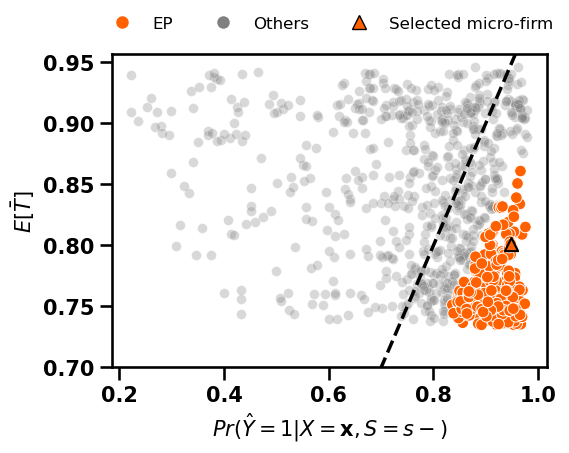

the data ratio is: 0.31378600823045266
#FF6100 Protected Pr(Y=1) Mean: 0.9130744385284352, Standard Deviation: 0.032073262245015846
#FF6100 Matched Mean Pr(Y=1) Mean: 0.7624547783951101, Standard Deviation: 0.023816436674328405


C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\analysis\extreme_analysis.py:193: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data1, shade=False, color=color, linewidth=7, label='Micro-firms', linestyle='--')
C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\analysis\extreme_analysis.py:194: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=False, color=density_color, linewidth=7, label='Peers group')


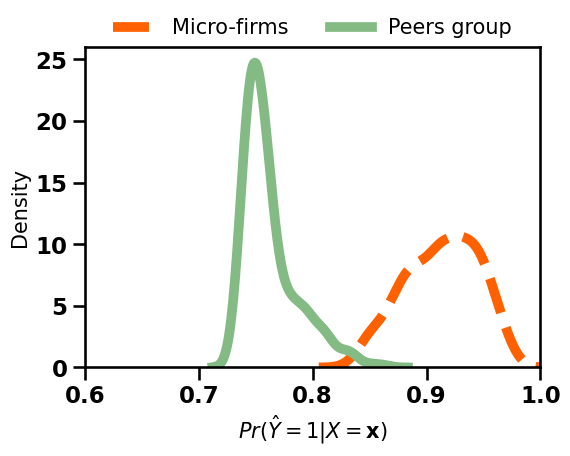

Kurtosis: 0.6335424299592498
Standard Deviation: 0.024314548834705806
Density Mean: 0.8009586857719211
Line Value (A): 0.9476871061703177


C:\Users\s2285280\code_publish\examples_model\size_xgb_fitting\../..\analysis\extreme_analysis.py:637: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade=False, bw_adjust=bw_adjust, color=density_color, linewidth=7, label='Peers')


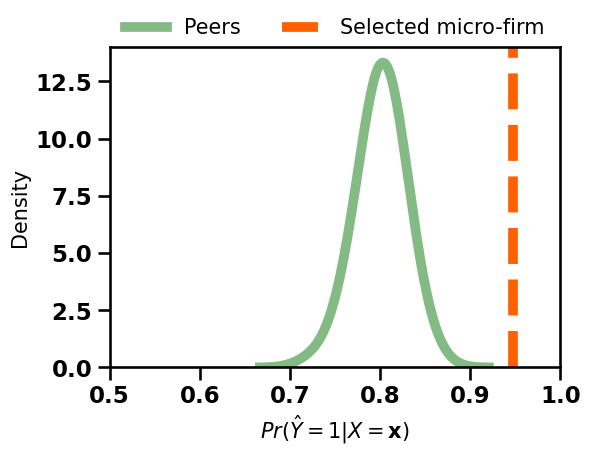

In [32]:
from analysis import extreme_analysis
from analysis.extreme_analysis import DensityScatterPlotter
plotter = DensityScatterPlotter(protect_df, nonprotect_df, bootstrapped_samples, result_type='single_less_sided_results', comparison_type='less than')
single_less_less_than_plot_df, single_less_less_than_gray_df, single_less_less_than_color_df = plotter.plot_scatter(pr_y_means, 1718, single_less_sided_results, threshold_type='floating', floating_ratio=0.1, mean_diff_threshold=treatment_threshold, p_value_threshold=0.05)

plotter.plot_group_density(single_less_less_than_color_df, 'protected Pr(Y=1)', 'matched mean Pr(Y=1)', '#FF6100', density_color='#84BA84')
plotter.plot_case_density(protect_df,pr_y_means, 1718, show_line=True, line_color='#FF6100', density_color='#84BA84')

In [33]:
line_5, b = plotter.try_2(single_less_less_than_color_df,pr_y_means,label='single_less_less than')

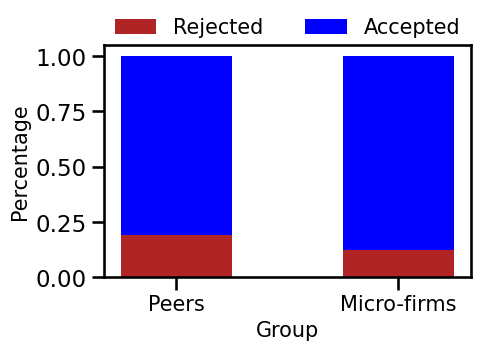

,Type,Binary Y,Count,Proportion
0,Nonprotect,0,173752,0.189893
1,Nonprotect,1,741248,0.810107
2,Protect,0,38,0.124590
3,Protect,1,267,0.875410


In [34]:
single_less_less_than_group_results = plotter.group_ground_truth(single_less_less_than_color_df,label='single_less_less than')
single_less_less_than_group_results

#

# (7) Validation of peer-induced framework

Difference for ED: 0.36094218942189427
Difference for FT: 0.049240000000000034
Difference for EP: -0.06530273224043714


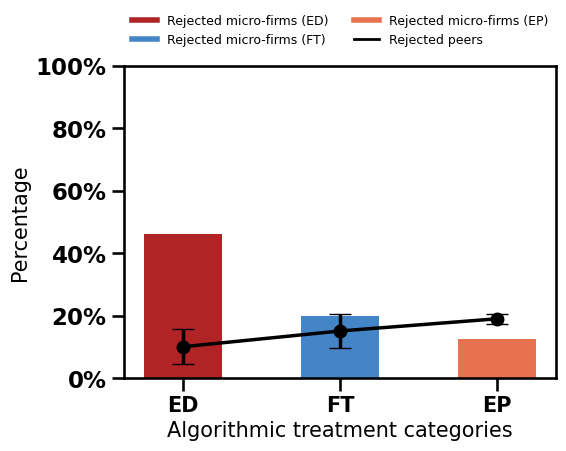

In [35]:
from analysis import outcomes_in_discrimination
from analysis.outcomes_in_discrimination import DiscriminationBarChart

dfs = [
    single_greater_less_than_group_results,
    double_fair_group_results,
    single_less_less_than_group_results
]


lines=[line_1,line_3,line_5]
plotter = DiscriminationBarChart(dfs, lines)
outcomes_in_discrimination_df = plotter.extract_data()
plotter.plot_stacked_bar_chart()

In [37]:
from analysis import outcomes_in_discrimination
from analysis.outcomes_in_discrimination import DiscriminationBarChart

dfs = [
    single_greater_less_than_group_results,
    single_greater_between_group_results,
    double_fair_group_results,
    single_less_between_group_results,
    single_less_less_than_group_results
]


lines=[line_1,line_2,line_3,line_4,line_5]
plotter = DiscriminationBarChart(dfs, lines)
outcomes_in_discrimination_df = plotter.extract_data()
plotter.plot_stacked_bar_chart()